Install required packages (for notebook and chatbot)

In [41]:
# Install everything needed (run only once)
!pip install faiss-cpu sentence-transformers rank_bm25 transformers datasets evaluate rouge_score
!pip install openai cohere langdetect googletrans==4.0.0-rc1 gtts speechrecognition
!pip install llama-cpp-python matplotlib streamlit



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


Imports and API Keys (FREE LLMs)

In [42]:
import os, time, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from langdetect import detect
from sentence_transformers import SentenceTransformer, CrossEncoder
!pip install evaluate

import evaluate

from rank_bm25 import BM25Okapi

from llama_cpp import Llama
import cohere
import openai

# 📌 Set your free API keys
COHERE_API_KEY = "31UJCywsyTx7K7nOtVpzAF7jlzXHqta1sfKIOETT"         # https://dashboard.cohere.com
OPENROUTER_API_KEY = "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" # https://openrouter.ai (uses LLaMA2 13B Chat)

openai.api_key = OPENROUTER_API_KEY
co = cohere.Client(COHERE_API_KEY)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


Define Test Queries

In [43]:
# 📍 Define 5 ERP test queries to evaluate across all models
erp_test_queries = [
    {"query": "Compare Odoo and SAP Business One for manufacturing businesses.", "answer": "Odoo is modular and open-source. SAP Business One is better for structured manufacturing and reporting."},
    {"query": "What are the features of Oracle NetSuite?", "answer": "NetSuite features include financials, CRM, e-commerce, and global business management."},
    {"query": "Suggest a cloud-based ERP for small enterprises.", "answer": "Acumatica, NetSuite, and Odoo are good cloud ERP options for small enterprises."},
    {"query": "Explain the pros and cons of Acumatica ERP.", "answer": "Acumatica is flexible and cloud-based but may lack some advanced analytics."},
    {"query": "Which ERP is best for supply chain management?", "answer": "IFS Applications and Oracle NetSuite are strong choices for supply chain management."}
]


# For few-shot, we’ll reuse these as examples (you can later replace with your own).
shots = {
    "1-shot": [
        {
            "query": "What is Odoo used for?",
            "answer": "Odoo is a suite of open-source business apps used for CRM, accounting, inventory, and eCommerce."
        }
    ],
    "3-shot": [
        {
            "query": "What is Odoo used for?",
            "answer": "Odoo is a suite of open-source business apps used for CRM, accounting, inventory, and eCommerce."
        },
        {
            "query": "List benefits of SAP Business One.",
            "answer": "SAP Business One provides real-time analytics, integrated financials, and inventory control for SMEs."
        },
        {
            "query": "Is Infor CloudSuite good for manufacturing?",
            "answer": "Yes, it offers strong production planning, quality control, and machine integration."
        }
    ]
}



Prompting Strategies

In [ ]:
def format_prompt(query, num_shots=0):
    """Return prompt with specified number of few-shot examples."""
    examples = [
        ("What are the features of Acumatica?",
         "Acumatica offers real-time dashboards, mobile access, and integrated financials and CRM."),
        ("Compare Oracle NetSuite and SAP Business One.",
         "Oracle NetSuite is cloud-native and customizable. SAP Business One is hybrid and suits SMEs."),
        ("Which ERP tool supports discrete manufacturing?",
         "Infor CloudSuite Industrial and IFS Applications are best for discrete manufacturing.")
    ]

    prompt = ""
    if num_shots >= 1:
        for q, a in examples[:num_shots]:
            prompt += f"Q: {q}\nA: {a}\n\n"
    prompt += f"Q: {query}\nA:"
    return prompt


Response Generation Functions for All 3 Models


In [45]:
# Cell 5: Response Generation Functions

import requests

def generate_openai(prompt, temperature=0.7, top_p=1.0):
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json"
    }
    body = {
        "model": "openai/gpt-3.5-turbo",  # required by OpenRouter
        "messages": [{"role": "user", "content": prompt}],
        "temperature": temperature,
        "top_p": top_p,
        "max_tokens": 300
    }
    try:
        res = requests.post("https://openrouter.ai/api/v1/chat/completions", headers=headers, json=body, timeout=15)
        return res.json()['choices'][0]['message']['content'].strip()
    except:
        return "[OpenRouter Error]"


def generate_cohere(prompt, temperature=0.7, top_p=1.0):
    headers = {
        "Authorization": f"Bearer {COHERE_API_KEY}",
        "Content-Type": "application/json"
    }
    body = {
        "model": "command-r-plus",
        "prompt": prompt,
        "temperature": temperature,
        "p": top_p,
        "max_tokens": 300
    }
    try:
        res = requests.post("https://api.cohere.ai/v1/generate", headers=headers, json=body, timeout=15)
        if res.status_code != 200:
            print("Cohere error:", res.text)
        return res.json()['generations'][0]['text'].strip()
    except Exception as e:
        print(f"[Cohere API Error] {e}")
        return "[Cohere Error]"


def generate_mistral(prompt, temperature=0.7, top_p=1.0):
    try:
        output = mistral_model(
            f"[INST] {prompt} [/INST]",
            max_tokens=300,
            temperature=temperature,
            top_p=top_p,
            stop=["</s>"]
        )
        return output["choices"][0]["text"].strip()
    except:
        return "[Mistral Error]"
    

# Local Mistral model init (define only once)
mistral_model = Llama(
    model_path="models/mistral-7b-instruct-v0.3-q4_k_m.gguf",
    n_ctx=2048,
    n_threads=4,
    n_gpu_layers=20,
    temperature=0.6,
    top_p=0.95,
    repeat_penalty=1.1
)

# Registry of model names → generation functions
model_registry = {
    "OpenRouter (LLaMA2)": generate_openai,
    "Cohere Command-R": generate_cohere,
    "Local Mistral-7B": generate_mistral
}



llama_model_load_from_file_impl: using device Metal (Apple M3) - 13558 MiB free
llama_model_loader: loaded meta data with 37 key-value pairs and 291 tensors from models/mistral-7b-instruct-v0.3-q4_k_m.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Mistral 7B Instruct v0.3
llama_model_loader: - kv   3:                            general.version str              = v0.3
llama_model_loader: - kv   4:                           general.finetune str              = Instruct
llama_model_loader: - kv   5:                           general.basename str              = Mistral
llama_model_loader: - kv   6:                         gene

Evaluation Metrics (BLEU, ROUGE, F1, Latency, Length)

In [46]:
# Cell 6: Evaluation Metrics
from evaluate import load
from sklearn.metrics import f1_score
import re, time

bleu_metric = load("bleu")
rouge_metric = load("rouge")

def clean_text(txt):
    txt = re.sub(r'\s+', ' ', txt)
    return txt.strip().lower()

def compute_metrics(reference, prediction, start_time):
    prediction = clean_text(prediction)
    reference = clean_text(reference)

    bleu = bleu_metric.compute(predictions=[prediction], references=[[reference]])['bleu']
    rouge = rouge_metric.compute(predictions=[prediction], references=[reference])['rougeL']

    # Convert words to binary bag-of-words for F1
    pred_tokens = set(prediction.split())
    ref_tokens = set(reference.split())
    all_tokens = list(pred_tokens.union(ref_tokens))
    y_true = [1 if token in ref_tokens else 0 for token in all_tokens]
    y_pred = [1 if token in pred_tokens else 0 for token in all_tokens]

    f1 = f1_score(y_true, y_pred)

    latency = round(time.time() - start_time, 2)
    length = len(prediction.split())

    return {
        "BLEU": round(bleu, 3),
        "ROUGE-L": round(rouge, 3),
        "F1": round(f1, 3),
        "Latency": latency,
        "Length": length
    }


def construct_prompt(query_text, shot_type):
    if shot_type == "zero_shot":
        return f"Q: {query_text}\nA:"
    elif shot_type == "one_shot":
        return format_prompt(query_text, shots=1)
    elif shot_type == "three_shot":
        return format_prompt(query_text, shots=3)
    else:
        raise ValueError("Invalid shot type")



Run Experiments and Collect Results

In [47]:
# Cell 7: Run experiments for all models and shots

import pandas as pd


results = []

for query_id, query in enumerate(erp_test_queries):
    for model_name, generator_fn in model_registry.items():
        for shot_type in ["zero_shot", "one_shot", "three_shot"]:
            prompt = construct_prompt(query["query"], shot_type)
            start = time.time()
            response = generator_fn(prompt)
            metrics = compute_metrics(query["answer"], response, start)

            results.append({
                "query_id": query_id,
                "query": query["query"],
                "ground_truth": query["answer"],
                "model": model_name,
                "shot": shot_type,
                "response": response,
                **metrics
            })

df_results = pd.DataFrame(results)
df_results["model"].replace({"OpenAI": "OpenRouter (LLaMA2)"}, inplace=True)

df_results.to_csv("llm_comparison_results.csv", index=False)
df_results.head()


llama_perf_context_print:        load time =     418.85 ms
llama_perf_context_print: prompt eval time =     418.78 ms /    24 tokens (   17.45 ms per token,    57.31 tokens per second)
llama_perf_context_print:        eval time =   17371.08 ms /   299 runs   (   58.10 ms per token,    17.21 tokens per second)
llama_perf_context_print:       total time =   17839.97 ms /   323 tokens
Llama.generate: 5 prefix-match hit, remaining 58 prompt tokens to eval
llama_perf_context_print:        load time =     418.85 ms
llama_perf_context_print: prompt eval time =    1115.06 ms /    58 tokens (   19.23 ms per token,    52.02 tokens per second)
llama_perf_context_print:        eval time =   17412.99 ms /   299 runs   (   58.24 ms per token,    17.17 tokens per second)
llama_perf_context_print:       total time =   18578.76 ms /   357 tokens
Llama.generate: 46 prefix-match hit, remaining 89 prompt tokens to eval
llama_perf_context_print:        load time =     418.85 ms
llama_perf_context_print: pr

query_id                                              query  \
0         0  Compare Odoo and SAP Business One for manufact...   
1         0  Compare Odoo and SAP Business One for manufact...   
2         0  Compare Odoo and SAP Business One for manufact...   
3         0  Compare Odoo and SAP Business One for manufact...   
4         0  Compare Odoo and SAP Business One for manufact...   

                                        ground_truth                model  \
0  Odoo is modular and open-source. SAP Business ...  OpenRouter (LLaMA2)   
1  Odoo is modular and open-source. SAP Business ...  OpenRouter (LLaMA2)   
2  Odoo is modular and open-source. SAP Business ...  OpenRouter (LLaMA2)   
3  Odoo is modular and open-source. SAP Business ...     Cohere Command-R   
4  Odoo is modular and open-source. SAP Business ...     Cohere Command-R   

         shot                                           response   BLEU  \
0   zero_shot  Odoo and SAP Business One are both popular ERP...  0.011   
1    one_shot  Odoo and SAP Business One are both popular ERP...  0.024   
2  three_shot  Odoo is more suitable for small to medium-size...  0.086   
3   zero_shot  Odoo and SAP Business One are both popular ent...  0.012   
4    one_shot  Odoo and SAP Business One are both robust ERP ...  0.017   

   ROUGE-L     F1  Latency  Length  
0    0.100  0.134     4.05     266  
1    0.130  0.140     2.76     167  
2    0.364  0.409     1.13      38  
3    0.091  0.106     5.53     230  
4    0.099  0.118     6.14     222

Visualize Evaluation Metrics (Bar & Line Charts)

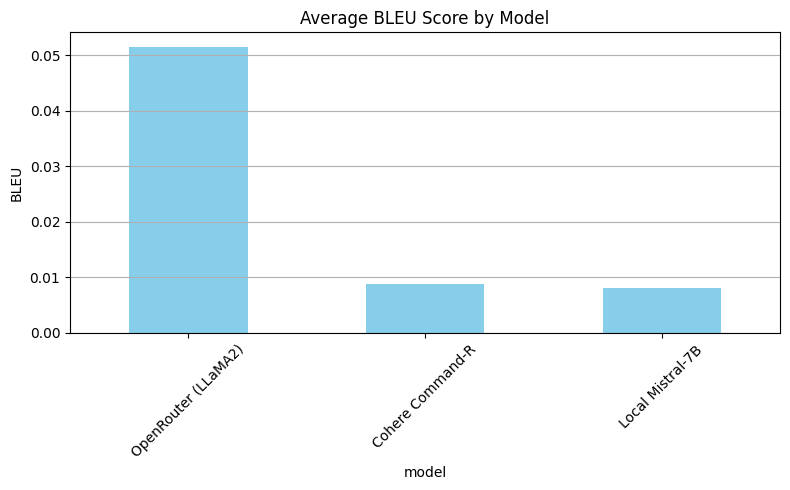

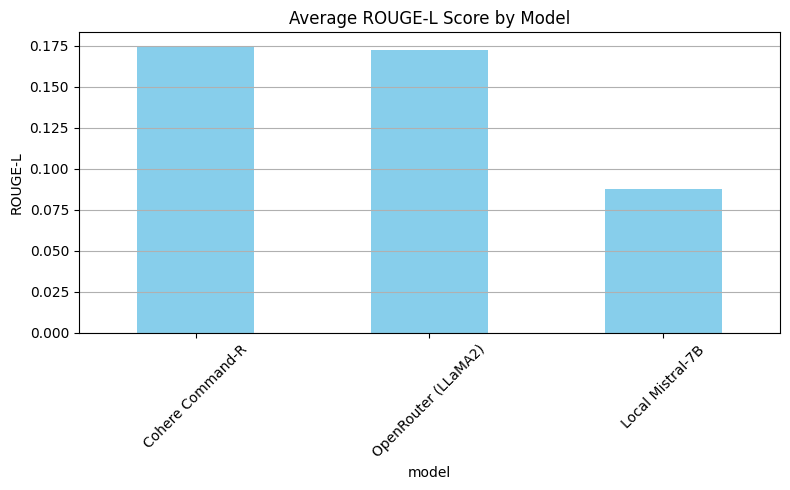

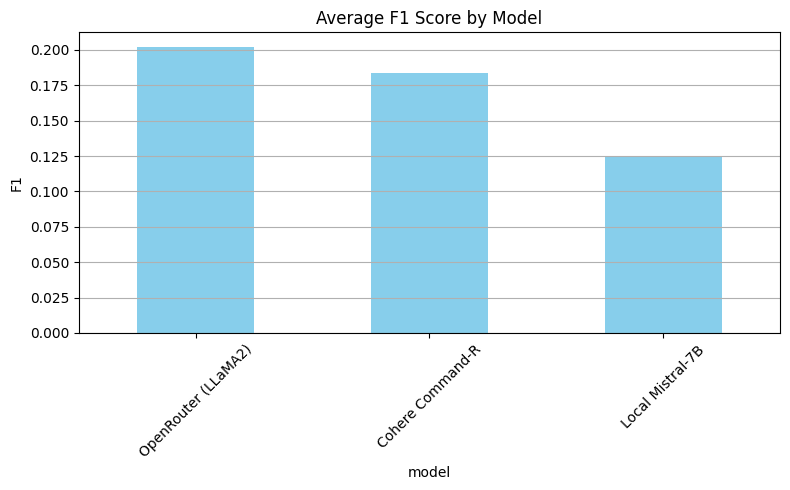

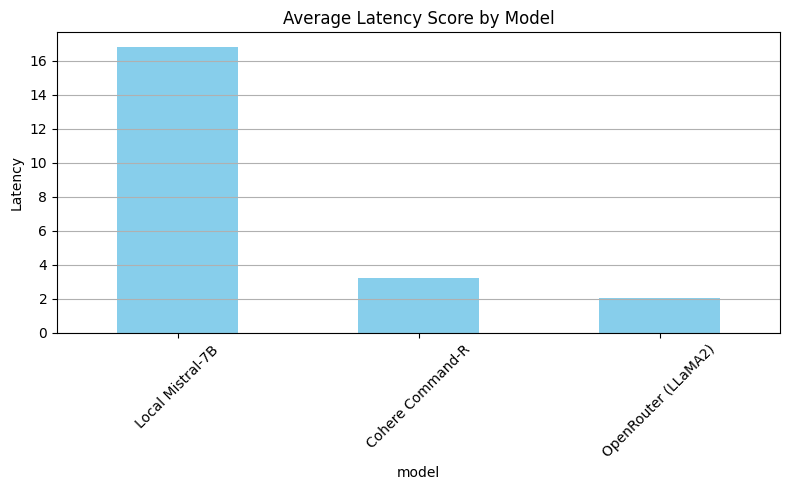

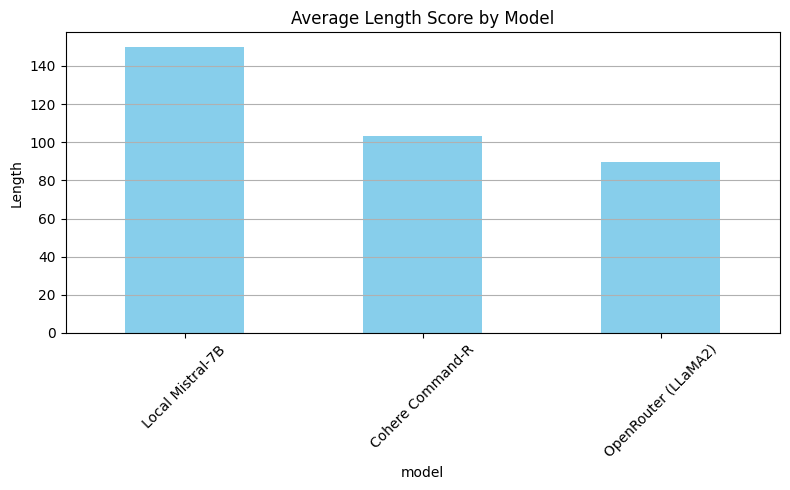

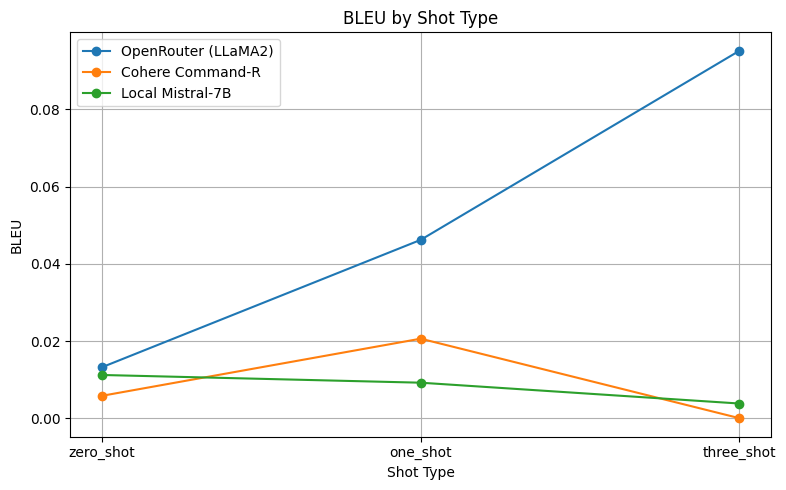

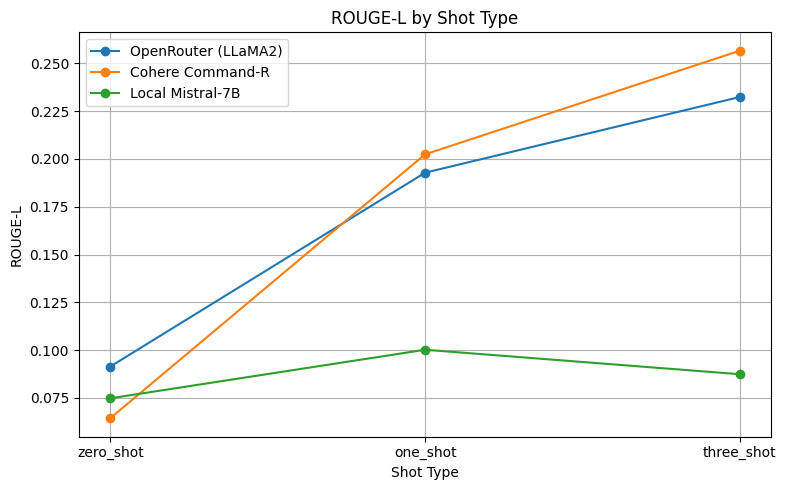

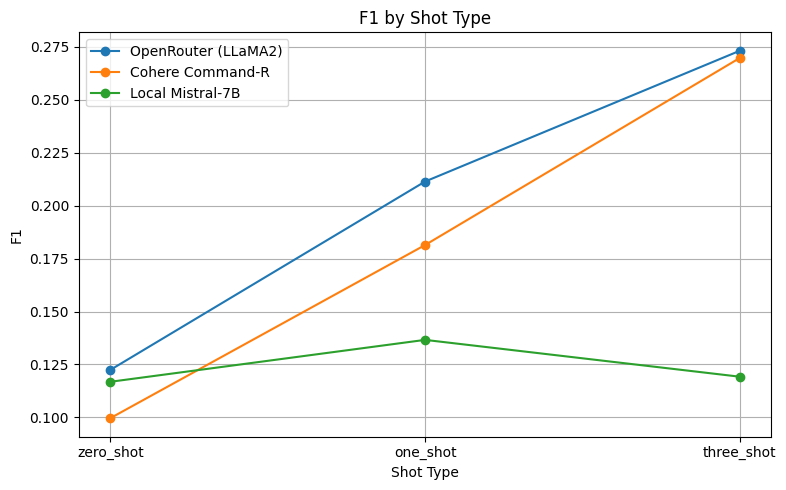

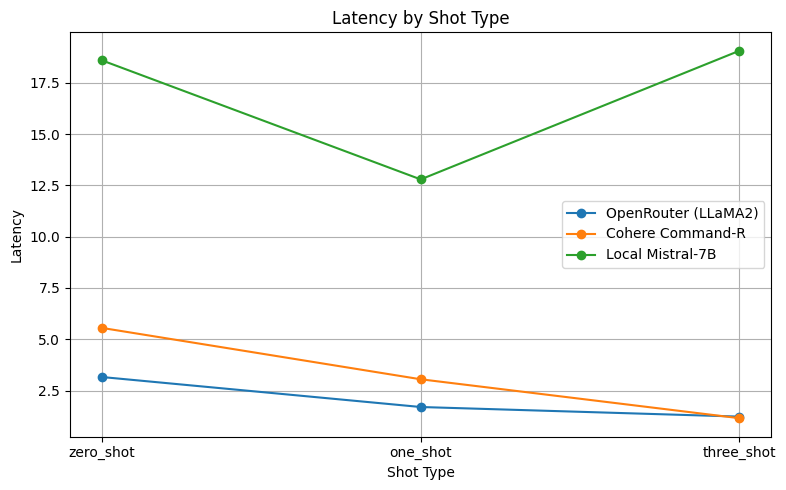

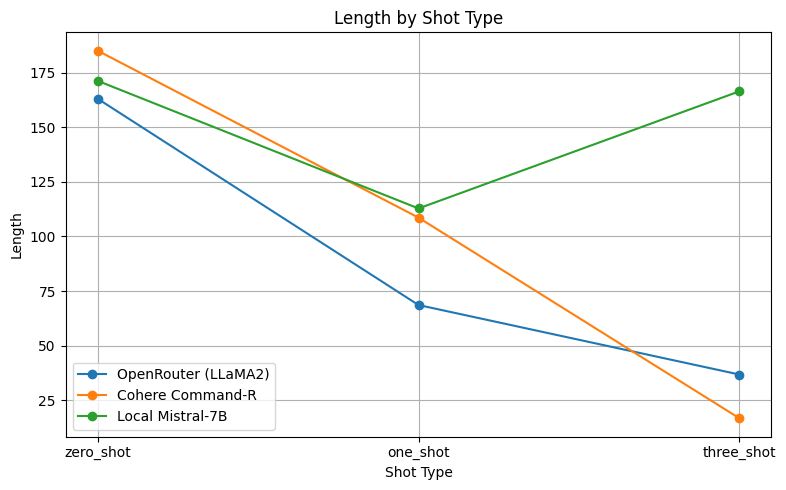

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.read_csv("llm_comparison_results.csv")

metrics = ["BLEU", "ROUGE-L", "F1", "Latency", "Length"]
shots = ["zero_shot", "one_shot", "three_shot"]
models = df_results["model"].unique()

# Bar plot for each metric (average per model)
for metric in metrics:
    plt.figure(figsize=(8, 5))
    df_results.groupby("model")[metric].mean().sort_values(ascending=False).plot(kind="bar", color="skyblue")
    plt.title(f"Average {metric} Score by Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# Line plot per shot type
for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model in models:
        model_data = df_results[df_results["model"] == model]
        scores = model_data.groupby("shot")[metric].mean().reindex(shots)
        plt.plot(shots, scores, marker="o", label=model)
    plt.title(f"{metric} by Shot Type")
    plt.xlabel("Shot Type")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Best Model Selection + Hyperparameter Tuning

In [49]:
# Determine best model by average F1
best_model = df_results.groupby("model")["F1"].mean().idxmax()
print("Best model based on F1 Score:", best_model)

# Tune temperature + top_p
tuning_results = []

for temp in [0.3, 0.5, 0.7]:
    for top_p in [0.8, 0.9, 1.0]:
        for q in shots["3-shot"]:
            prompt = format_prompt(q["query"], shots=3)
            start = time.time()

            if best_model == "Local Mistral":
                out = generate_mistral(prompt, temperature=temp, top_p=top_p)
            elif best_model == "OpenRouter GPT":
                out = generate_openai(prompt, temperature=temp, top_p=top_p)
            elif best_model == "Cohere Command-R":
                out = generate_cohere(prompt, temperature=temp, top_p=top_p)
            else:
                out = "[Unknown Model]"

            f1 = compute_metrics(q["answer"], out, start)["F1"]
            tuning_results.append({
                "model": best_model,
                "temperature": temp,
                "top_p": top_p,
                "query": q["query"],
                "f1": f1
            })

df_tune = pd.DataFrame(tuning_results)
best_params = df_tune.sort_values("f1", ascending=False).iloc[0]
print("Best hyperparameters:", best_params)


Best model based on F1 Score: OpenRouter (LLaMA2)


TypeError: list indices must be integers or slices, not str